In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0,'..')
from src.misc.separator import splitDataFrameList

In [2]:
def split_test_acc_list(df):
    return splitDataFrameList(df,'test_acc',',')

In [3]:
def split_uncertainty_known_list(df):
    return splitDataFrameList(df,'uncertainty_known',',')

In [4]:
def model_selection_gnn(df):
    return df[df.val_avg == df.groupby('arch').val_avg.transform(max)]

In [5]:
datasets = 'cora citeseer pubmed cora_full chameleon squirrel webkb actor'.split()# amazon_electronics_computers amazon_electronics_photo ms_academic_cs ms_academic_phy wiki_cs'.split()

models = 'gcn'.split()
# experiments = 'global_hubs global_edges'.split()

In [6]:
dataset_formal_name = {'cora':'CORA-ML', 'citeseer':'CiteSeer' ,'pubmed':'PubMed', 'cora_full':'CORA-Full',
              'cornell':'Cornell', 'texas':'Texas', 'washington':'Washington',  'wisconsin':'Wisconsin',
              'twitter':'Twitter', 'webkb':'WebKB',
                   'amazon_electronics_computers':'Amazon Computer', 'amazon_electronics_photo':'Amazon Photo',
                   'ms_academic_cs':'Coauthor CS', 'ms_academic_phy':'Coauthor Physics', 'wiki_cs':'Wiki-CS',
                      'actor':'Actor', 'chameleon':'Chameleon','squirrel':'Squirrel'}

In [7]:
def load_model_results(models,datasets):
    dfs = []
    for model in models:
        for dataset in datasets:
            if not os.path.exists(f'../reports/results/test_acc/{model}_{dataset}_sbm_swap.csv'):
                continue
            df = pd.read_csv(f'../reports/results/test_acc/{model}_{dataset}_sbm_swap.csv')
            df['dataset'] = dataset
#                 df = model_selection_gnn(df)
            dfs.append(df)
    return pd.concat(dfs,ignore_index=True,sort=False)

In [8]:
def load_original(models, datasets):
    dfs = []
    for model in models:
        for dataset in datasets:
            if not os.path.exists(f'../reports/results/test_acc/{model}_{dataset}.csv'):
                continue
            df = pd.read_csv(f'../reports/results/test_acc/{model}_{dataset}.csv')
            df['dataset'] = dataset
            df = df[((df.splits == 100) & (df.inits == 20)) | ((df.splits == 20) & (df.inits == 5))]
            df = df[df.arch == 'M']
            df = model_selection_gnn(df)
            dfs.append(df)
    return pd.concat(dfs,ignore_index=True,sort=False)
    

In [39]:
view_columns = 'dataset conv sbm_num uncertainty uncertainty_known ratio test_accs'.split()
df_results = load_model_results(models,datasets)
df_results = df_results[view_columns].rename(columns={'test_accs':'test_acc'})
df_results = split_test_acc_list(df_results)
df_results = split_uncertainty_known_list(df_results)
df_results = df_results.groupby('dataset conv sbm_num uncertainty uncertainty_known'.split()).mean().reset_index()
df_results.ratio = df_results.ratio.astype(int)
df_results = df_results.rename(columns={'ratio':'swap_percentage'})

In [40]:
view_columns = 'dataset conv arch test_accs'.split()
df_original = load_original(models, datasets)
df_original = df_original[view_columns].rename(columns={'test_accs':'test_acc','arch':'directionality'})
df_original = split_test_acc_list(df_original)

In [41]:
df_results[(df_results.dataset == 'actor') & (df_results.swap_percentage == 10) & (df_results.sbm_num == 0)].head(20)

,dataset,conv,sbm_num,uncertainty,uncertainty_known,swap_percentage,test_acc
30,actor,GCNConv,0.0,0.005126,0.143423,10,0.239064
31,actor,GCNConv,0.0,0.005126,0.159187,10,0.239064
32,actor,GCNConv,0.0,0.005126,0.165856,10,0.239064
33,actor,GCNConv,0.0,0.005126,0.186601,10,0.239064
34,actor,GCNConv,0.0,0.005126,0.189023,10,0.239064


In [42]:
def get_original(dataset,model):
    return df_original[(df_original.conv == model) & (df_original.dataset == dataset)].test_acc.mean()

In [43]:
sns.set(color_codes=True)

In [44]:
def plot(dataset, model, df, savefig_to=None,known=False):
    df = df[(df.dataset == dataset) & (df.conv == model)]
    plt.figure()
    g = sns.regplot(data=df, x='uncertainty_known' if known else 'uncertainty', y='test_acc',)#hue='swap_percentage',palette=sns.color_palette(n_colors=len(df.swap_percentage.unique())))
#     g.axhline(get_original(dataset,model), ls='--',c='r')
#     plt.legend(bbox_to_anchor=(1.02,0., .102,  1.), loc='lower left',)
    plt.title(dataset)
    plt.xlabel('U(L|C)')
    plt.ylabel('Accuracy')
    if savefig_to is not None:
        plt.savefig(savefig_to,bbox_inches='tight')
    plt.show()

In [45]:
def plot_ulc(dataset, model, df, savefig_to=None):
    df = df[(df.dataset == dataset) & (df.conv == model)]
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))
#     plt.figure()
    g = sns.regplot(data=df, x='uncertainty_known', y='test_acc',ax=ax1)
#     plt.figure()
    df = df['swap_percentage uncertainty uncertainty_known'.split()]
    df = df.rename(columns={'uncertainty':'Actual', 'uncertainty_known':'Estimated'})
    g = sns.lineplot(data=pd.melt(df,['swap_percentage']).rename(columns={'variable':'U(L|C)'}) ,
                     x='swap_percentage', y='value',hue='U(L|C)',palette=sns.color_palette(n_colors=2),ax=ax2)
#     g.axhline(get_original(dataset,model), ls='--',c='r')
    plt.title(dataset)
    plt.ylabel('U(L|C)')
    plt.xlabel('Swap Percentage')#hue='swap_percentage',palette=sns.color_palette(n_colors=len(df.swap_percentage.unique())))

    if savefig_to is not None:
        plt.savefig(savefig_to,bbox_inches='tight')
    plt.show()

In [46]:
# xx = pd.melt(df_results,['dataset','swap_percentage']).rename(columns={'variable':'U(L|C)'})
# xx[xx['U(L|C)'].isin(['uncertainty', 'uncertainty_known'])]


In [47]:
def split_test_acc_list(df):
    return splitDataFrameList(df,'test_acc',',')
def baseline(dataset,q=0.5):
    if dataset not in datasets:
        dataset = dataset_name_remap[dataset]
    return df_baseline[df_baseline.dataset==dataset].test_acc.quantile(q=q)
def baseline_mean(dataset):
    return df_baseline[df_baseline.dataset==dataset].test_acc.mean()
def baseline_std(dataset):
    return df_baseline[df_baseline.dataset==dataset].test_acc.std()
# feats baseline to be revised
df_baseline = pd.read_csv('../reports/results/test_acc/features-only-baseline.csv')
df_baseline['method'] = 'baseline'
df_baseline = split_test_acc_list(df_baseline).drop(columns=['test_std','test_avg'])
df_baseline = df_baseline[df_baseline.dataset.isin(datasets)]

In [48]:
def plot_ulc(model, df, height=3, per_row=1):
    df = df.loc[(df.conv == model)]
    
#     plt.figure()
#     g = sns.FacetGrid(df, col='dataset',row=None,sharey=True,height=height,ylim=[0,1],xlim=[0,0.7])#,legend_out=legend_out
#     bp = g.map(sns.regplot, 'uncertainty','test_acc',)
#     bp.set_titles("{col_name}")
#     bp.set_ylabels("Accuracy")
#     bp.set_xlabels("Actual U(L|C)")
#     plt.savefig(f'../reports/figures/swap/sbm-swap-correlation.pdf',bbox_inches='tight')
    df.dataset = df.dataset.apply(lambda x:dataset_formal_name[x])
    datasets = df.dataset.unique()
    for i in range(0,len(datasets),per_row):
        plt.figure()
        cdf = df.loc[df.dataset.isin(datasets[(i):(i+per_row)])].copy()
        print(cdf.dataset.unique())
        
# -------------------------------------------------------
#     cmap = plt.get_cmap('RdYlGn')
#     vmin=0
#     vmax=1
#     if vertical:
#         bp = g.map(plot_type, x_col,y_col,hue_col,
# #                  marker="o",
# #                order=order,
#                hue_order=(sorted(df[hue_col].unique()) if hue_order is None else hue_order),
#                palette=cmap,
#                    hue_norm=(0,1),
# #                    vmin=vmin, vmax=vmax, cmap=cmap,
#                    s=200,alpha=0.45,
#                   )
# #         # Make space for the colorbar
# -------------------------------------------------------
        g = sns.FacetGrid(cdf, col='dataset',row=None,sharey=True,height=height,ylim=[0,1],xlim=[0,1],aspect=1)
        
        bp = g.map(sns.scatterplot, 'uncertainty_known','test_acc')
        bp.set_titles("{col_name}")
        bp.set_ylabels("Accuracy")
        bp.set_xlabels(r'$U(L|C)$')

#         g.set(xticks=[.0,.25,.50,.75,1.])
    #     for ax,dataset in zip(g.axes[0],datasets):
    #         ax.axhline(baseline(dataset), ls='--',c='r')

        plt.savefig(f'../reports/figures/swap/sbm-swap-correlation-known-{(i)}-{(i+per_row)}.pdf',bbox_inches='tight')
    
    
    df = df.rename(columns={'uncertainty':'Actual', 'uncertainty_known':'Estimated'})
    
#     df = pd.melt(df,['dataset','swap_percentage'])
#     df = df[df['variable'].isin(['Actual', 'Estimated'])]
#     print(df.value.describe())
#     g = sns.FacetGrid(df, col='dataset',row=None,sharey=True)#,legend_out=legend_out
#     bp = g.map(sns.lineplot, 'swap_percentage','value','variable')
    
    
#     g = sns.FacetGrid(df, col='dataset',row=None,sharey=True,height=height)#,legend_out=legend_out
#     bp = g.map(sns.lineplot, 'swap_percentage','Actual')
#     bp = g.map(sns.lineplot, 'swap_percentage','Estimated')
#     bp.set_titles("")
#     bp.set_ylabels("U(L|C)")
#     bp.set_xlabels("Swap percentage")
    df1 = df['dataset swap_percentage Actual'.split()]
    df1['U(L|C)'] = 'Actual'
    df1 = df1.rename(columns={'Actual':'value'})
    df2 = df['dataset swap_percentage Estimated'.split()]
    df2['U(L|C)'] = 'Estimated'
    df2 = df2.rename(columns={'Estimated':'value'})
#     df = pd.concat([df1,df2])
    df = pd.concat([df2])
    df.swap_percentage = df.swap_percentage/100
    for i in range(0,len(datasets),per_row):
        plt.figure()
        cdf = df.loc[df.dataset.isin(datasets[(i):(i+per_row)])].copy()
        g = sns.FacetGrid(cdf, col='dataset',row=None,sharey=True,height=height,legend_out=True,ylim=[0,1],xlim=[0,1],aspect=1)
        bp = g.map(sns.lineplot, 'swap_percentage','value','U(L|C)')
        bp.set_ylabels("U(L|C)")
        bp.set_xlabels("Swap fraction")
        bp.set_titles("{col_name}")
#         g.set(xticks=[.0,.25,.50,.75,1.])
    #     print(df)
    #     g = sns.regplot(data=df, x='uncertainty_known', y='test_acc',ax=ax1)
    #     df = df['swap_percentage uncertainty uncertainty_known'.split()]
    #     df = df.rename(columns={'uncertainty':'Actual', 'uncertainty_known':'Estimated'})
    #     g = sns.lineplot(data=df, x='swap_percentage', y='value',hue='U(L|C)',palette=sns.color_palette(n_colors=2))
    # #     g.axhline(get_original(dataset,model), ls='--',c='r')
    #     plt.title(dataset)
    #     plt.ylabel('U(L|C)')
    #     plt.xlabel('Swap Percentage')#hue='swap_percentage',palette=sns.color_palette(n_colors=len(df.swap_percentage.unique())))

        plt.savefig(f'../reports/figures/swap/sbm-swap-ulc-{(i)}-{(i+per_row)}.pdf',bbox_inches='tight')
        plt.show()


In [49]:
df_results.dataset = pd.Categorical(df_results['dataset'], datasets)
df_results = df_results.sort_values('dataset')

In [50]:
df_results.dataset = df_results.apply(lambda x:str(x['dataset']),axis=1)

['CORA-ML' 'CiteSeer' 'PubMed' 'CORA-Full']
['Chameleon' 'Squirrel' 'WebKB' 'Actor']


/home/hhussain/anaconda3/envs/ans1/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/hhussain/anaconda3/envs/ans1/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 432x288 with 0 Axes>

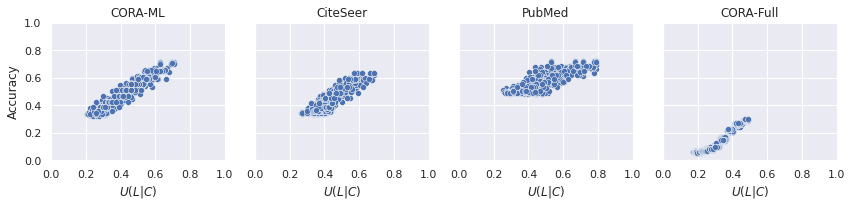

<Figure size 432x288 with 0 Axes>

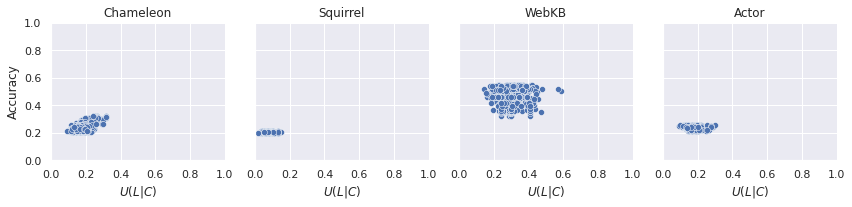

<Figure size 432x288 with 0 Axes>

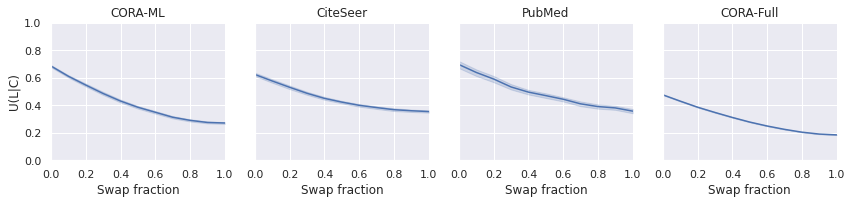

<Figure size 432x288 with 0 Axes>

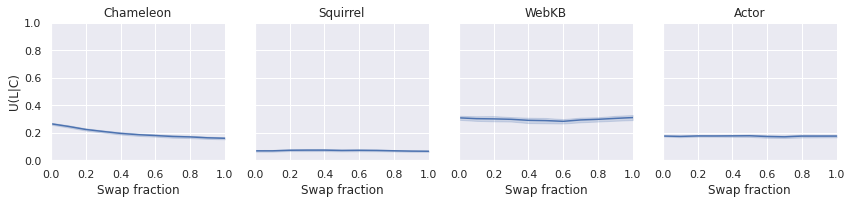

In [51]:
for model in df_results.conv.unique():
    plot_ulc(model, df_results,height=3,per_row=4)

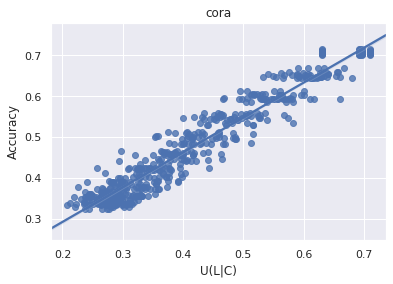

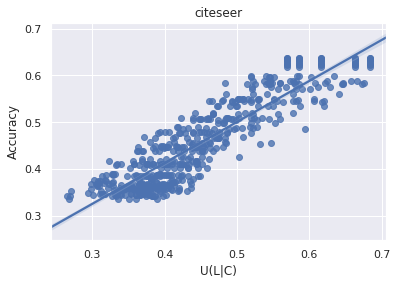

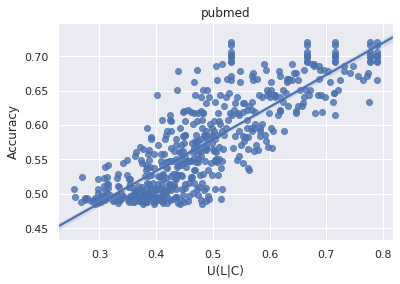

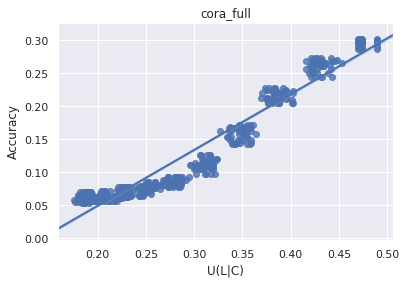

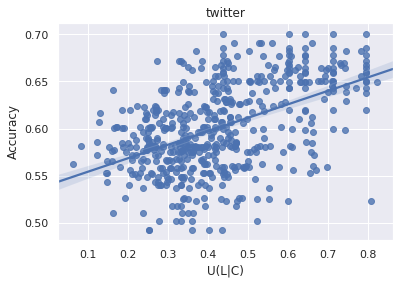

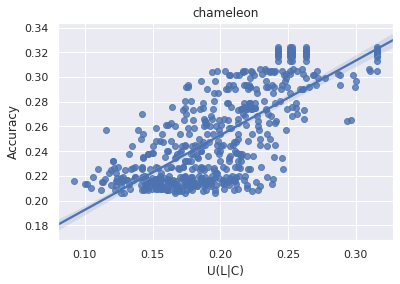

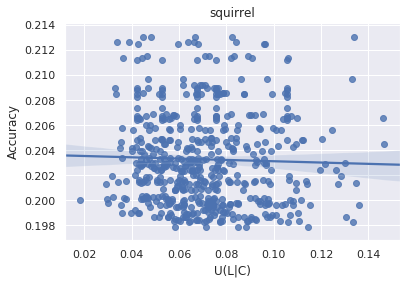

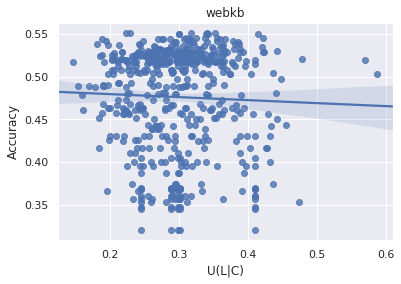

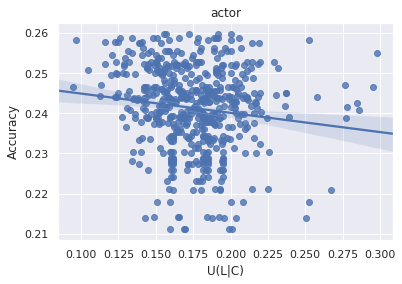

In [61]:
for dataset in df_results.dataset.unique():
    for model in df_results.conv.unique():
        plot(dataset, model, df_results,f'../reports/figures/swap/sbm-swap-known-{dataset}.pdf', known=True)